In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer, Reshape, Dropout, Conv2D, UpSampling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from PIL import Image


In [5]:
file_path = '/content/drive/MyDrive/homeDesign/datasets/data10.xlsx'
data = pd.read_excel(file_path)

# Print the column names to verify
print("Columns in the dataset:", data.columns)


Columns in the dataset: Index(['shape_num', 'num_of_room', 'elevated_or_not', 'image_path'], dtype='object')


In [6]:
def preprocess_image(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))  # Resize to a common size
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalize pixel values
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Apply preprocessing to each image path
data['image_array'] = data['image_path'].apply(preprocess_image)

# Drop rows where image couldn't be loaded
data = data.dropna(subset=['image_array'])

# Convert the image data to numpy array format
image_arrays = np.array(data['image_array'].tolist())
print(image_arrays.shape)


(420, 224, 224, 3)


In [7]:
# Ensure the feature columns exist
required_columns = ['shape_num', 'num_of_room', 'elevated_or_not']
missing_columns = [col for col in required_columns if col not in data.columns]
print(f"Missing columns in the dataset: {missing_columns}")

# Define the input features and labels
X = data[['shape_num', 'num_of_room', 'elevated_or_not']].values
y = image_arrays

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Missing columns in the dataset: []


In [8]:
# Build the CNN model
model = Sequential([
    InputLayer(input_shape=(3,)),  # Input layer with 3 features
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(56 * 56 * 64, activation='relu'),  # Output to match dimensions before upsampling
    Reshape((56, 56, 64)),  # Reshape to a smaller image size
    UpSampling2D(size=(2, 2)),  # Upsample to 112x112
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    UpSampling2D(size=(2, 2)),  # Upsample to 224x224
    Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')  # Output layer with 3 channels
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1024      
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 200704)            102961152 
                                                                 
 reshape (Reshape)           (None, 56, 56, 64)        0         
                                                                 
 up_sampling2d (UpSampling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      36928     
                                                        

In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/20
11/11 [==============================] - 103s 9s/step - loss: 0.1635 - accuracy: 0.7751 - val_loss: 0.0463 - val_accuracy: 0.9251
Epoch 2/20
11/11 [==============================] - 102s 9s/step - loss: 0.0503 - accuracy: 0.8971 - val_loss: 0.0500 - val_accuracy: 0.9251
Epoch 3/20
11/11 [==============================] - 104s 10s/step - loss: 0.0514 - accuracy: 0.8971 - val_loss: 0.0500 - val_accuracy: 0.9256
Epoch 4/20
11/11 [==============================] - 105s 10s/step - loss: 0.0514 - accuracy: 0.8977 - val_loss: 0.0500 - val_accuracy: 0.9263
Epoch 5/20
11/11 [==============================] - 98s 9s/step - loss: 0.0514 - accuracy: 0.8983 - val_loss: 0.0500 - val_accuracy: 0.9266
Epoch 6/20
11/11 [==============================] - 96s 9s/step - loss: 0.0514 - accuracy: 0.8987 - val_loss: 0.0500 - val_accuracy: 0.9267
Epoch 7/20
11/11 [==============================] - 104s 9s/step - loss: 0.0514 - accuracy: 0.8988 - val_loss: 0.0500 - val_accuracy: 0.9268
Epoch 8/20
11

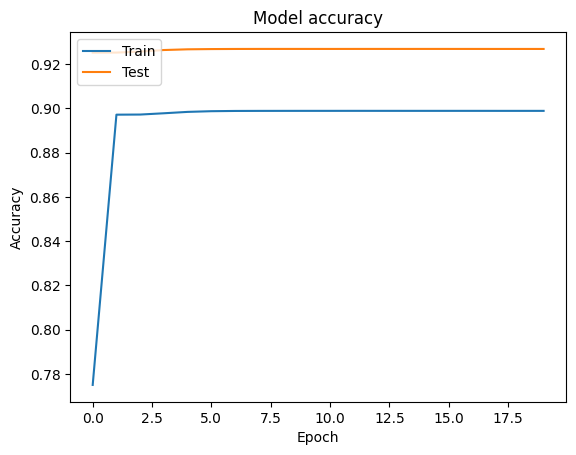

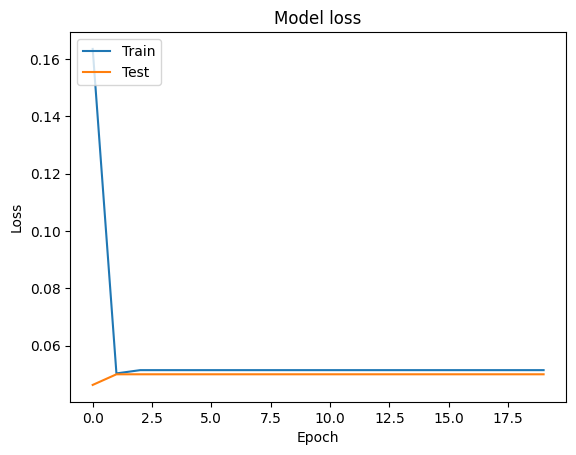

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


1/1 [==============================] - 0s 188ms/step
Predicted Image Path: /content/drive/MyDrive/homeDesign/images/circle/c1.jpg


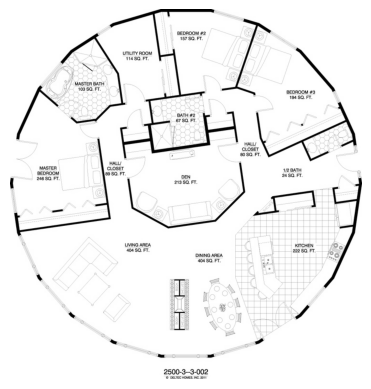

In [15]:

# Initialize the LabelEncoder
label_encoder = LabelEncoder()  # Create an instance of LabelEncoder
label_encoder.fit(data['image_path'])

# Function to generate a prediction
def generate_prediction(model, shape_num, num_of_room, elevated_or_not):
    input_data = np.array([[shape_num, num_of_room, elevated_or_not]])
    predicted_probabilities = model.predict(input_data)  # Get predicted probabilities
    predicted_label = np.argmax(predicted_probabilities, axis=1)  # Find index of class with highest probability
    # Reshape predicted_label to a 1D array before inverse transform
    predicted_label = predicted_label.reshape(-1,)
    predicted_image_path = label_encoder.inverse_transform(predicted_label)
    return predicted_image_path[0]

# Function to display the image
def display_image(image_path):
  image = Image.open(image_path)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

# Example prediction
shape_num = 1
num_of_room = 3
elevated_or_not = 0
predicted_image_path = generate_prediction(model, shape_num, num_of_room, elevated_or_not)

print(f"Predicted Image Path: {predicted_image_path}")

# Display the predicted image
display_image(predicted_image_path)







